# Covariate advection with varying diffusion 

### Neumann boundary conditions

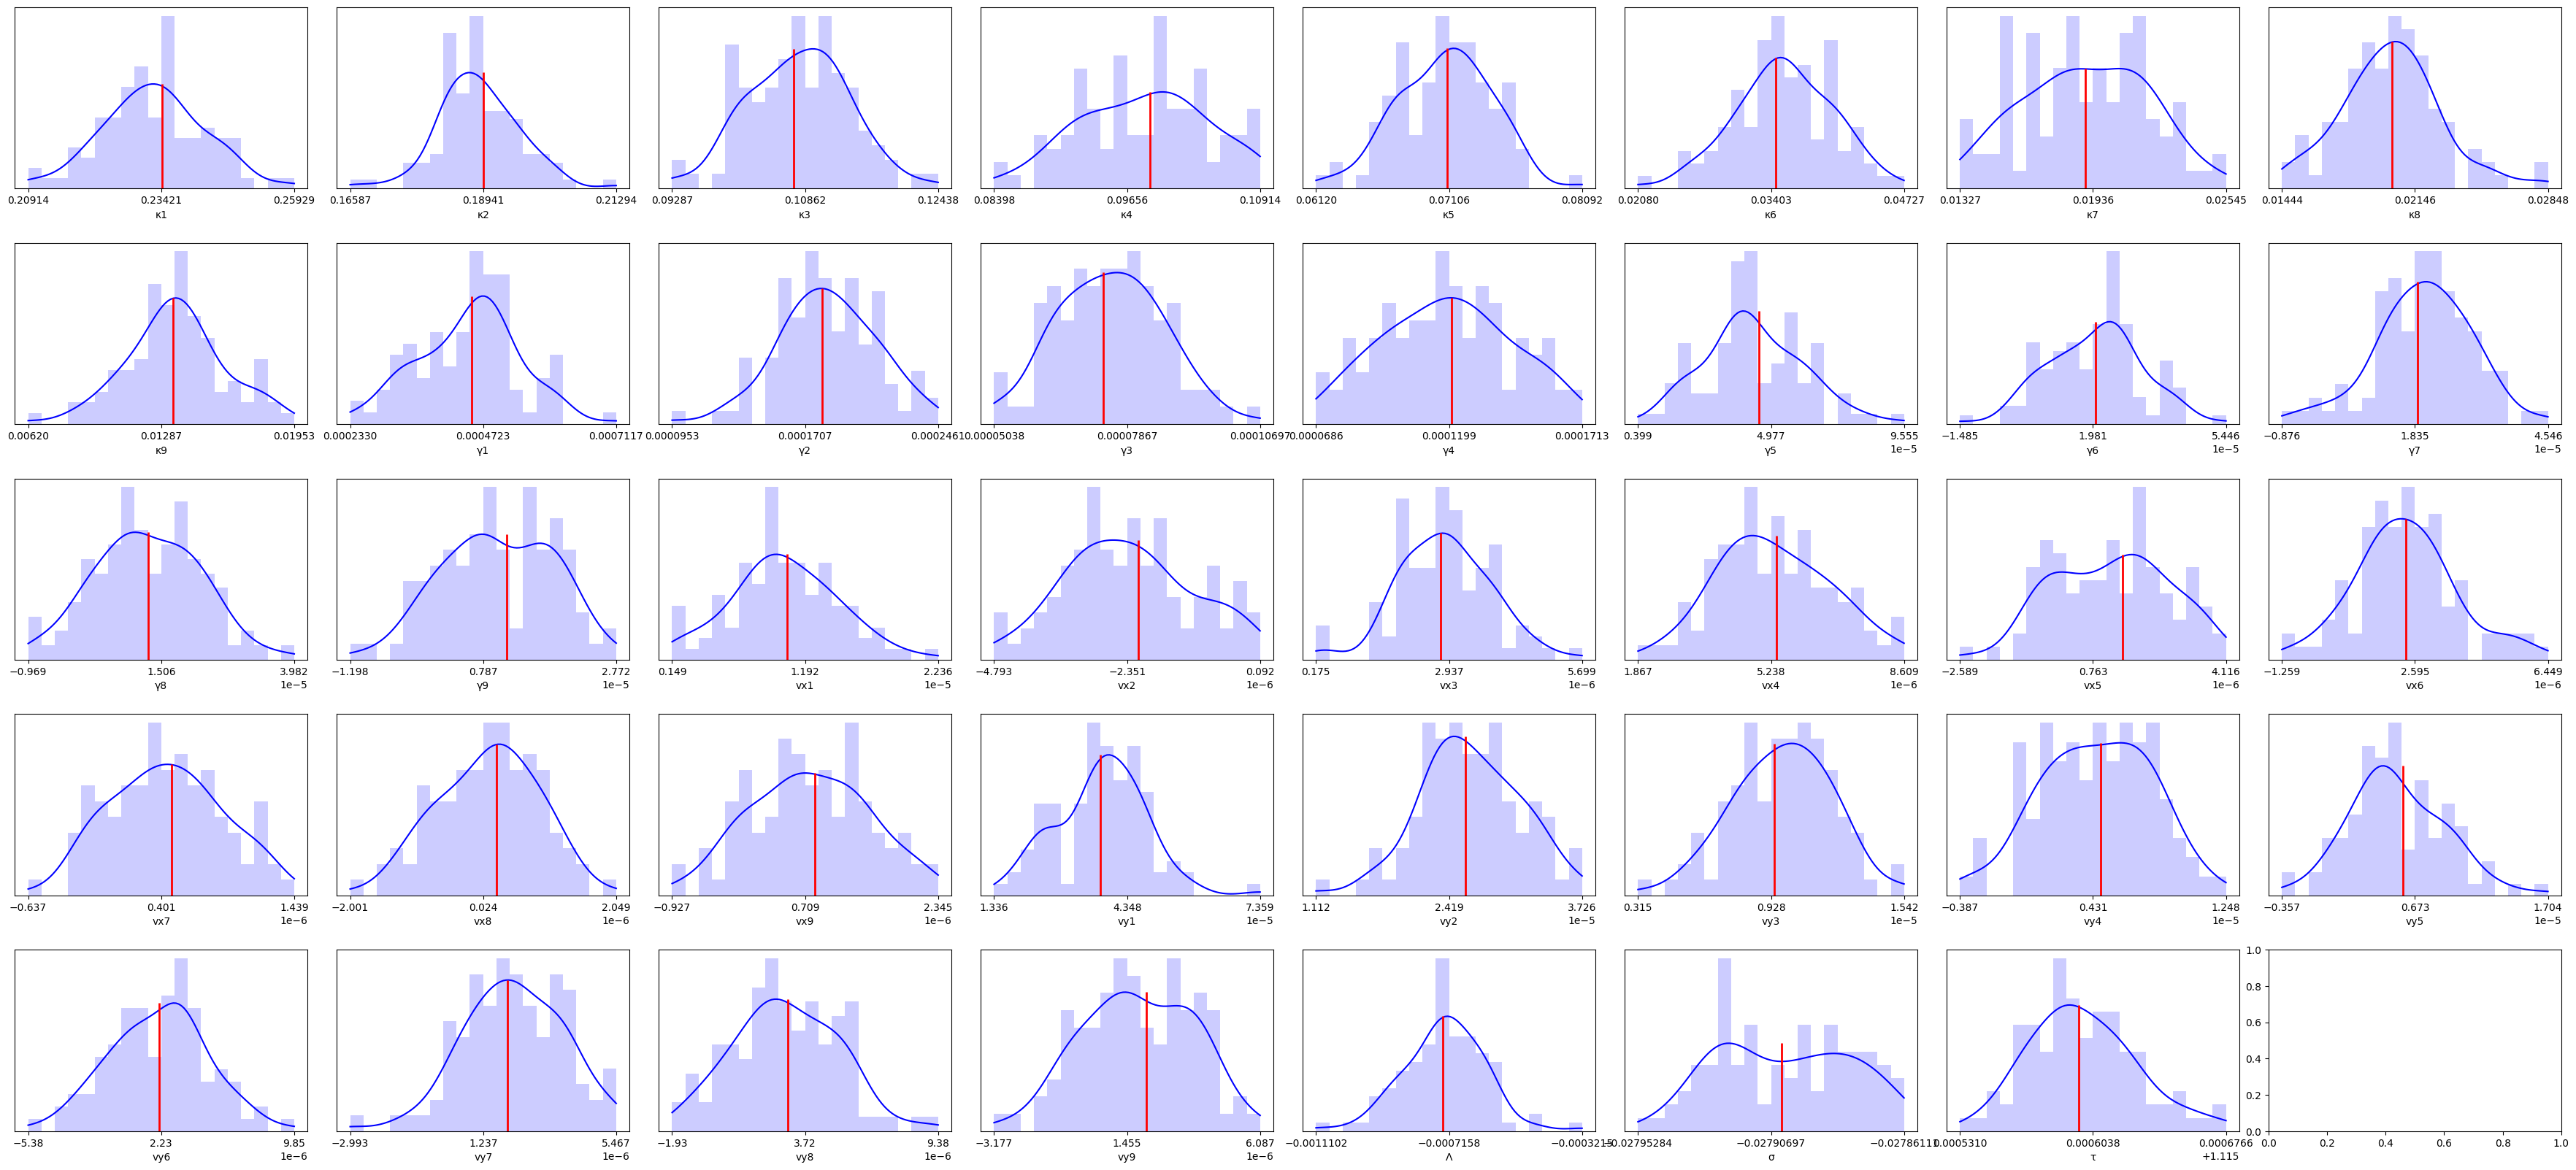

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
grad_res = np.load('../grad/cov-advection-var-diffusion-2D-bc1.npz')
ngrad = grad_res['ngrad']
sgrad = grad_res['sgrad']

m = 8
n = 5
fig, ax = plt.subplots(figsize = (45,20),ncols = m, nrows = n)
titles = np.hstack([["\u03BA%d"%i for i in range(1,10)], 
                    ["\u03B3%d"%i for i in range(1,10)], 
                    ["vx%d"%i for i in range(1,10)],
                    ["vy%d"%i for i in range(1,10)],
                    "\u039B", "\u03C3", "\u03C4"])
for i in range(m):
    for j in range(n):
        if i + j*m >= sgrad.shape[0]:
            break
        tx = np.linspace(sgrad[i + j*m,:].min(),sgrad[i+j*m,:].max(),100)
        ty = gaussian_kde(sgrad[i + j*m,:])(tx)
        ax[j,i].plot(tx,ty,'b')
        ax[j,i].hist(sgrad[i + j*m,:],density = True, bins = 20, color = 'b', alpha = 0.2)
        ax[j,i].vlines(x=ngrad[i + j*m],ymin = 0,ymax = ty.max(),colors='r',linewidth = 2)
        ax[j,i].set_xlabel(titles[i + j*m],fontsize = 10)
        ax[j,i].set_yticks([])
        ax[j,i].set_xticks(np.linspace(tx.min(),tx.max(),3))
fig.subplots_adjust(wspace = 0.1, hspace = 0.3)

### Dirichlet boundary conditions

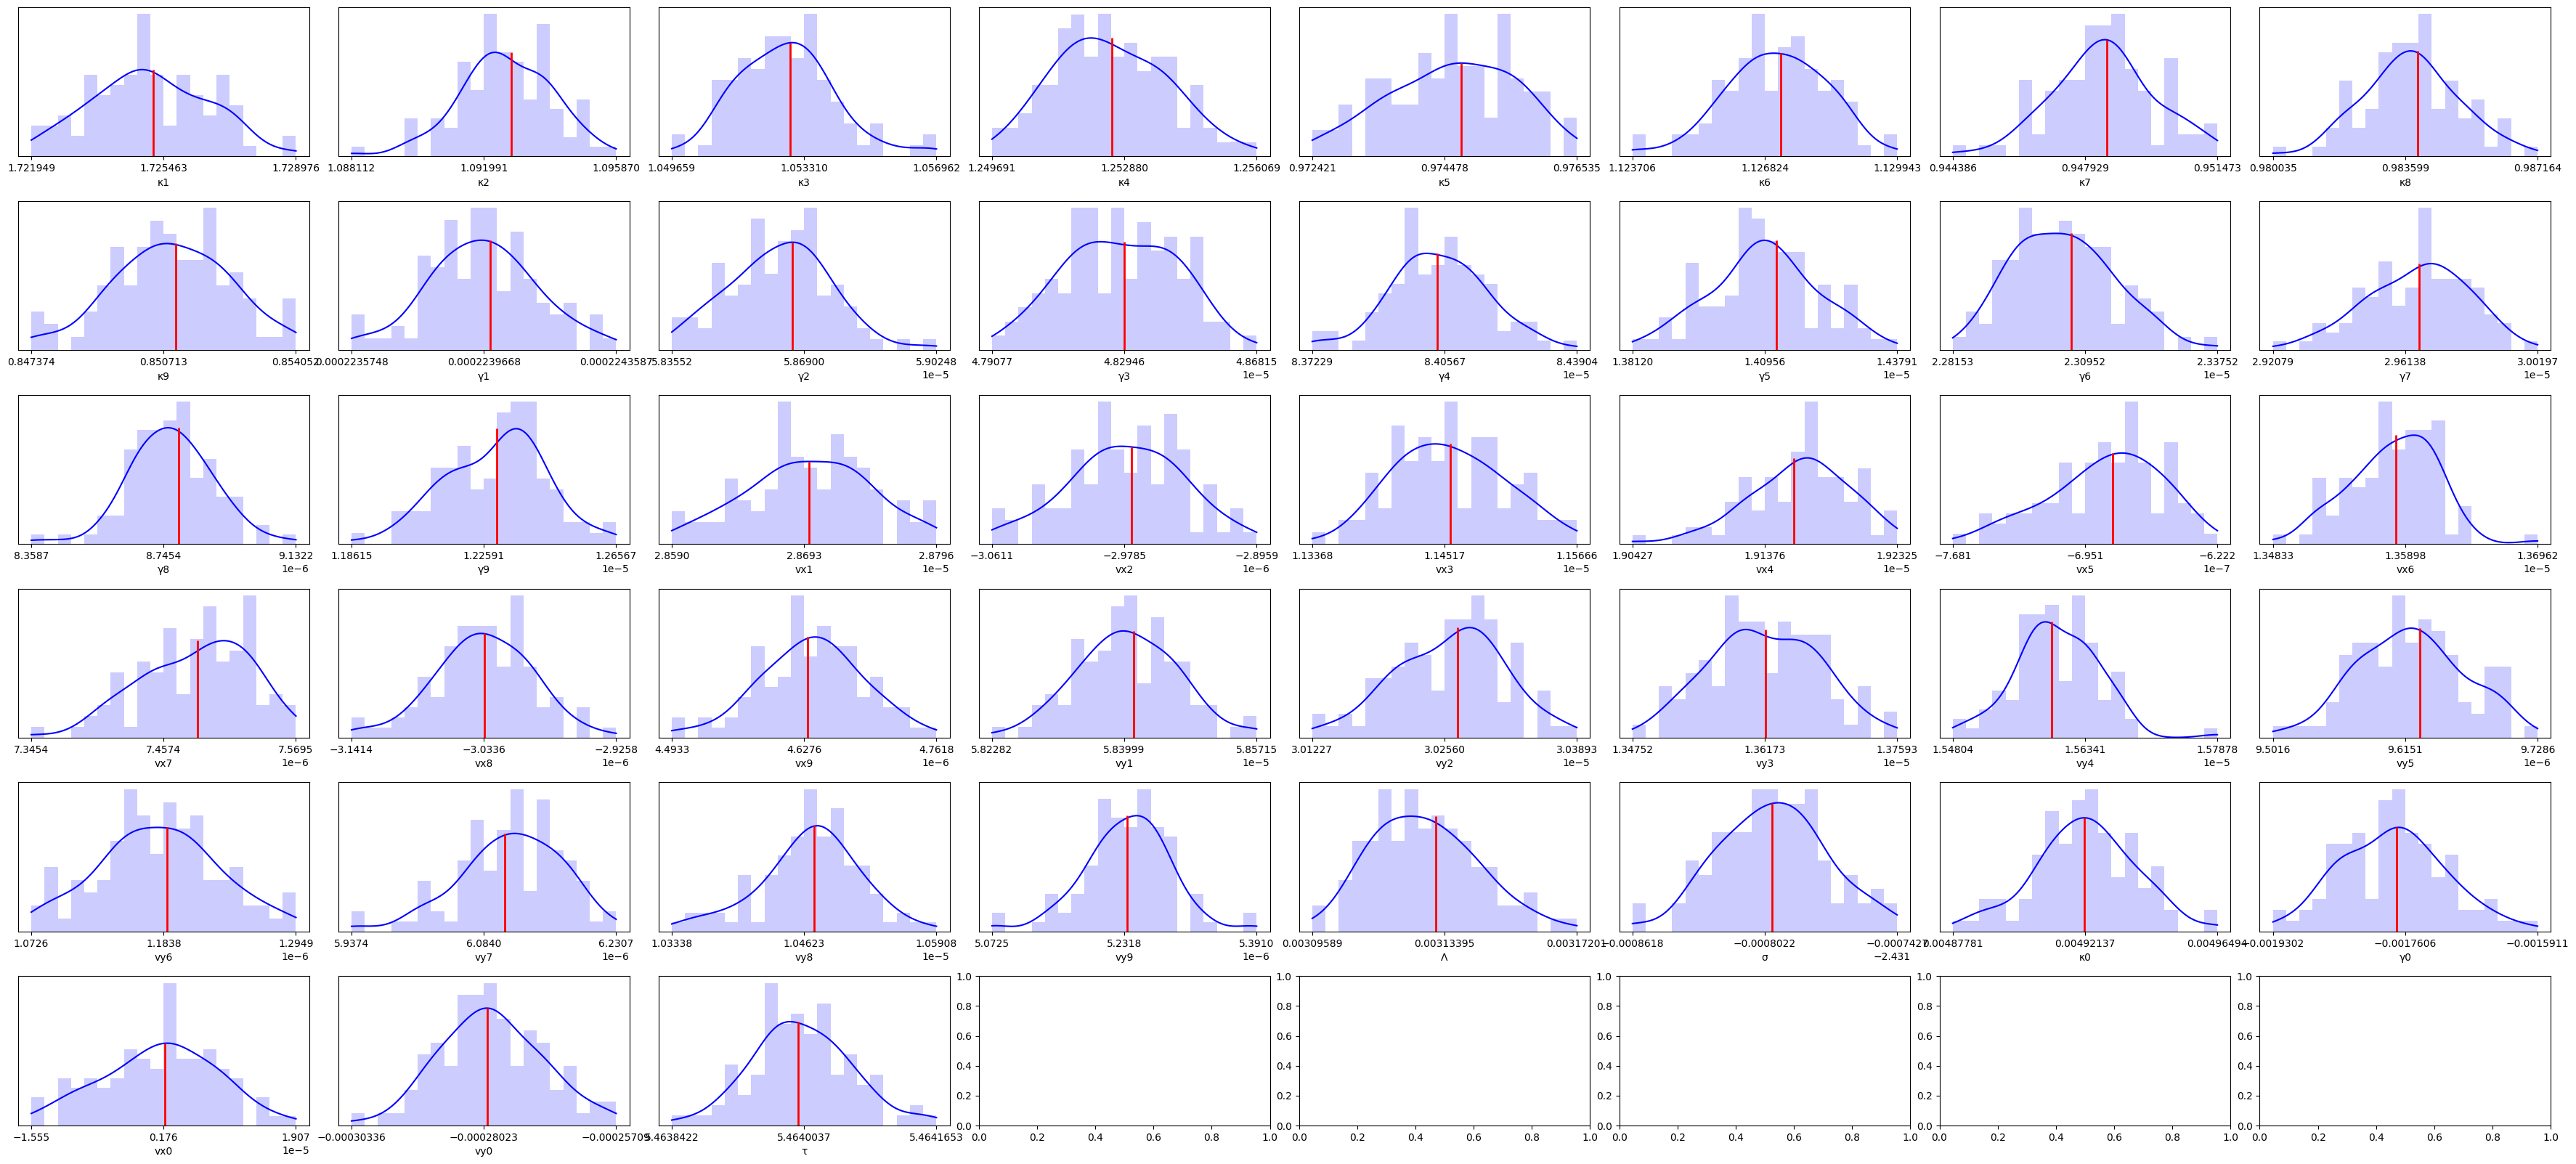

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
grad_res = np.load('../grad/cov-advection-var-diffusion-2D-bc3.npz')
ngrad = grad_res['ngrad']
sgrad = grad_res['sgrad']

m = 8
n = 6
fig, ax = plt.subplots(figsize = (45,20),ncols = m, nrows = n)
titles = np.hstack([["\u03BA%d"%i for i in range(1,10)], 
                    ["\u03B3%d"%i for i in range(1,10)], 
                    ["vx%d"%i for i in range(1,10)],
                    ["vy%d"%i for i in range(1,10)],
                    "\u039B", "\u03C3","\u03BA0", "\u03B30", "vx0" ,"vy0", "\u03C4"])
for i in range(m):
    for j in range(n):
        if i + j*m >= sgrad.shape[0]:
            break
        tx = np.linspace(sgrad[i + j*m,:].min(),sgrad[i+j*m,:].max(),100)
        ty = gaussian_kde(sgrad[i + j*m,:])(tx)
        ax[j,i].plot(tx,ty,'b')
        ax[j,i].hist(sgrad[i + j*m,:],density = True, bins = 20, color = 'b', alpha = 0.2)
        ax[j,i].vlines(x=ngrad[i + j*m],ymin = 0,ymax = ty.max(),colors='r',linewidth = 2)
        ax[j,i].set_xlabel(titles[i + j*m],fontsize = 10)
        ax[j,i].set_yticks([])
        ax[j,i].set_xticks(np.linspace(tx.min(),tx.max(),3))
fig.subplots_adjust(wspace = 0.1, hspace = 0.3)

#### Visualization

In [ ]:
import spdepy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm    

data = sp.datasets.get_sinmod_training()
bc = 3
spde = 'cov-advection-var-diffusion'
mod0 = sp.model(grid = sp.grid(x=data['x'], y=data['y'], extend = 5),
        spde = 'whittle-matern', parameters = np.load('../fits/whittle_matern_ani_bc%d.npy'%bc),
        ha = False, bc = bc, anisotropic = True)
mod = sp.model(grid = sp.grid(x=data['x'], y=data['y'], t = data['t'],extend = 5),
        spde = spde, ha = False, bc = bc, anisotropic = True, Q0 = mod0.mod.Q,
        parameters = np.load('../fits/%s_ani_bc%d.npy'%(spde,bc)))
ww = mod.grid.assimilate_adv(data['we'],data['wn'])
mod.mod.setQ()

#### Prediction on test set

In [4]:
import spdepy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm    

dataTe = sp.datasets.get_sinmod_test()
dataTr = sp.datasets.get_sinmod_training()
bc = 3
spde = 'cov-advection-var-diffusion'
mod0 = sp.model(grid = sp.grid(x=dataTr['x'], y=dataTr['y'], extend = 5),
        spde = 'whittle-matern', parameters = np.load('../fits/whittle_matern_ani_bc%d.npy'%bc),
        ha = False, bc = bc, anisotropic = True)
mod = sp.model(grid = sp.grid(x=dataTr['x'], y=dataTr['y'], t = dataTr['t'],extend = 5),
        spde = spde, ha = False, bc = bc, anisotropic = True, Q0 = mod0.mod.Q,
        parameters = np.load('../fits/cov_advection_var_diffusion_ani_bc%d.npy'%(bc)))
mod.mod.ww = mod.grid.assimilate_adv(dataTe['we'],dataTe['wn'])
mod.mod.setQ()

27.952296177702564


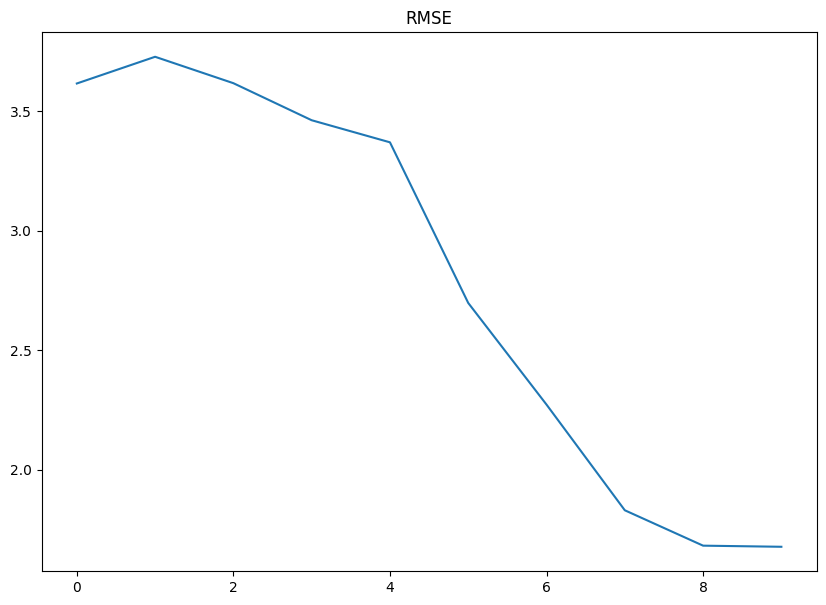

In [5]:
mod.setModel(mu = dataTr['muB'], sigmas = np.log(np.load("../fits/sinmod/sigmas.npy")),useCov = False)
res = np.zeros(10)
start = dataTe['data']['tidx'].min()
tidx = dataTe['data']['tidx'].values
data = dataTe['data']['data'].values
sds = dataTe['data']['var'].values
tau = (1/sds.mean())
idx = dataTe['data']['idx'].values

res[0] = np.sqrt(np.mean((mod.grid.getS(idxs = idx)@mod.mu - data)**2))
for k in range(9):
    rm = tidx == (start+k)
    idxs = idx[rm] + mod.grid.N*mod.grid.M*(k)
    mod.update(y = data[rm], idx = idxs,tau = tau)
    rmF = np.stack([tidx == (start+t) for t in range(k+1,10)],axis= 1)
    idxsF = np.hstack([idx[rmF[:,t-k-1]] + mod.grid.N*mod.grid.M*(t) for t in range(k+1,10)])
    res[k+1] = np.sqrt(np.mean((mod.grid.getS(idxs = idxsF)@mod.mu - np.hstack([data[rmF[:,t-k-1]] for t in range(k+1,10)]))**2))

fig,ax = plt.subplots(figsize = (10,7))
ax.plot(np.arange(10,dtype = "int32"),res,'-')
ax.set_title('RMSE')
print(res.sum())


36.86300478425011


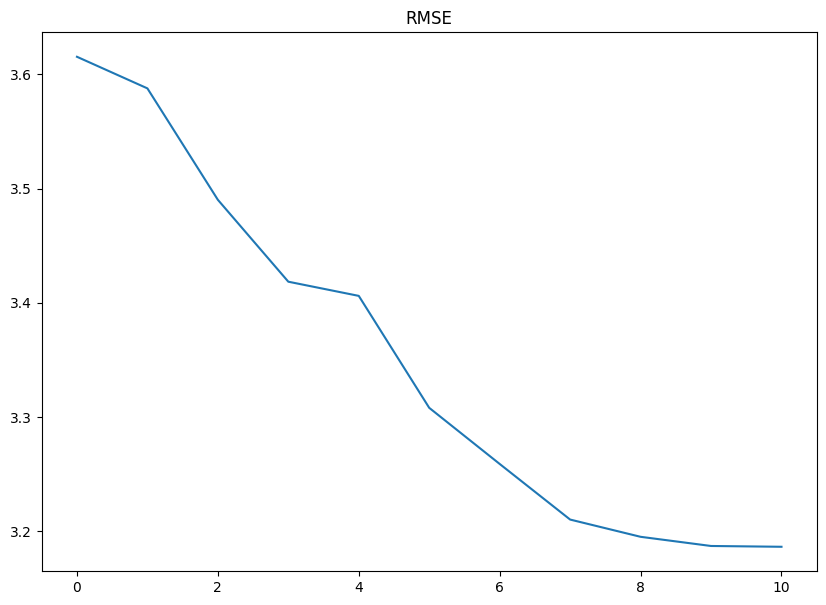

In [6]:
mod.setModel(mu = dataTr['muB'], sigmas = np.log(np.load("../fits/sinmod/sigmas.npy")),useCov = False)
res = np.zeros(11)
start = dataTe['data']['tidx'].min()
tidx = dataTe['data']['tidx'].values
data = dataTe['data']['data'].values
sds = dataTe['data']['var'].values
tau = (1/sds.mean())
idx = dataTe['data']['idx'].values
res[0] = np.sqrt(np.mean((mod.grid.getS(idxs = idx)@mod.mu - data)**2))
for k in range(10):
    rm = tidx == (start+k)
    idxs = idx[rm] + mod.grid.N*mod.grid.M*(k)
    mod.update(y = data[rm], idx = idxs,tau = tau)
    res[k+1] = np.sqrt(np.mean((mod.grid.getS(idxs = idx)@mod.mu - data)**2))

fig,ax = plt.subplots(figsize = (10,7))
ax.plot(np.arange(11,dtype = "int32"),res,'-')
ax.set_title('RMSE')
print(res.sum())

29.37195899911082


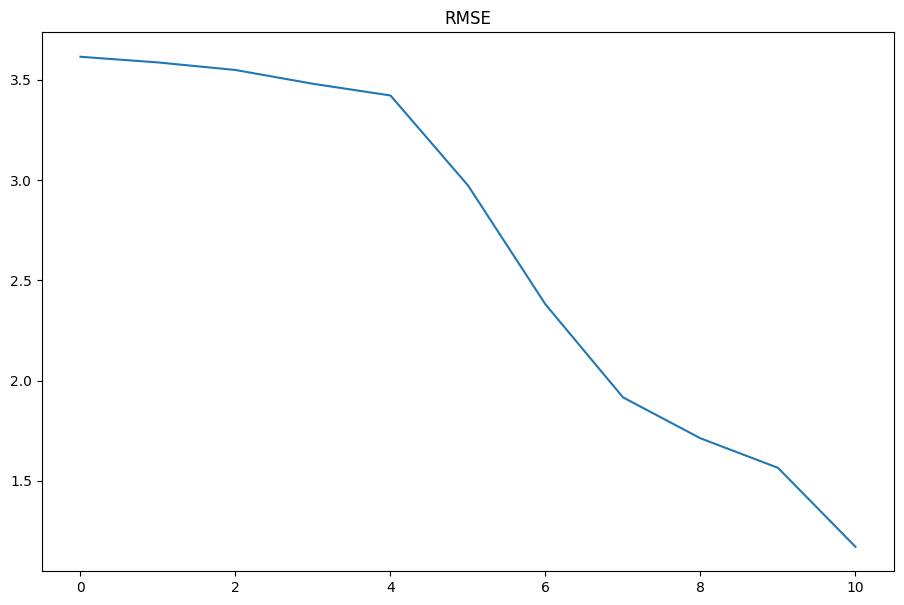

In [7]:
mod.setModel(mu = dataTr['muB'], sigmas = np.log(np.load("../fits/sinmod/sigmas.npy")),useCov = False)
res = np.zeros(11)
start = dataTe['data']['tidx'].min()
tidx = dataTe['data']['tidx'].values
data = dataTe['data']['data'].values
sds = dataTe['data']['var'].values
tau = (1/sds.mean())
idx = dataTe['data']['idx'].values

res[0] = np.sqrt(np.mean((mod.grid.getS(idxs = idx)@mod.mu - data)**2))
for k in range(10):
    rm = tidx == (start+k)
    idxs = idx[rm] + mod.grid.N*mod.grid.M*(k)
    mod.update(y = data[rm], idx = idxs,tau = tau)
    rmF = np.stack([tidx == (start+t) for t in range(k,10)],axis= 1)
    idxsF = np.hstack([idx[rmF[:,t-k]] + mod.grid.N*mod.grid.M*(t) for t in range(k,10)])
    res[k+1] = np.sqrt(np.mean((mod.grid.getS(idxs = idxsF)@mod.mu - np.hstack([data[rmF[:,t-k]] for t in range(k,10)]))**2))

fig,ax = plt.subplots(figsize = (11,7))
ax.plot(np.arange(11,dtype = "int32"),res,'-')
ax.set_title('RMSE')
print(res.sum())

##### With covariates

In [2]:
import spdepy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from tqdm import tqdm    

dataTe = sp.datasets.get_sinmod_test()
dataTr = sp.datasets.get_sinmod_training()
bc = 3
spde = 'cov-advection-var-diffusion'
mod0 = sp.model(grid = sp.grid(x=dataTr['x'], y=dataTr['y'], extend = 5),
        spde = 'whittle-matern', parameters = np.load('../fits/whittle_matern_ani_bc%d.npy'%bc),
        ha = False, bc = bc, anisotropic = True)
mod = sp.model(grid = sp.grid(x=dataTr['x'], y=dataTr['y'], t = dataTr['t'],extend = 5),
        spde = spde, ha = False, bc = bc, anisotropic = True, Q0 = mod0.mod.Q,
        parameters = np.load('../fits/cov_advection_var_diffusion_ani_bc%d.npy'%(bc)))
mod.mod.ww = mod.grid.assimilate_adv(dataTe['we'],dataTe['wn'])
mod.mod.setQ()

23.128866654578687


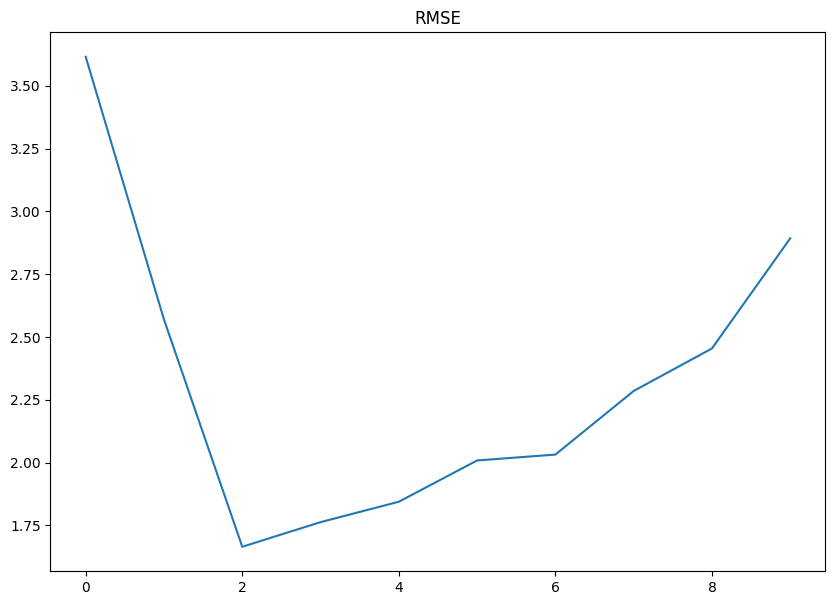

In [3]:
mod.setModel(mu = dataTr['muB'], sigmas = np.log(np.load("../fits/sinmod/sigmas.npy")),useCov = True)
res = np.zeros(10)
start = dataTe['data']['tidx'].min()
tidx = dataTe['data']['tidx'].values
data = dataTe['data']['data'].values
sds = dataTe['data']['var'].values
tau = (1/sds.mean())
idx = dataTe['data']['idx'].values

res[0] = np.sqrt(np.mean((mod.grid.getS(idxs = idx)@mod.mu - data)**2))
for k in range(9):
    rm = tidx == (start+k)
    idxs = idx[rm] + mod.grid.N*mod.grid.M*(k)
    mod.update(y = data[rm], idx = idxs,tau = tau)
    rmF = np.stack([tidx == (start+t) for t in range(k+1,10)],axis= 1)
    idxsF = np.hstack([idx[rmF[:,t-k-1]] + mod.grid.N*mod.grid.M*(t) for t in range(k+1,10)])
    res[k+1] = np.sqrt(np.mean((mod.grid.getS(idxs = idxsF)@mod.mu - np.hstack([data[rmF[:,t-k-1]] for t in range(k+1,10)]))**2))

fig,ax = plt.subplots(figsize = (10,7))
ax.plot(np.arange(10,dtype = "int32"),res,'-')
ax.set_title('RMSE')
print(res.sum())
